## Using AutoKeras 1.0.16.post1 to solve [Digit Recognizer Kaggle Competition](https://www.kaggle.com/c/digit-recognizer/overview)

### Install AutoKeras

In [ ]:
!pip3 install autokeras==1.0.16post1

### Unzip and upload datasets

Be minded that Tensorflow's built-in MNIST dataset has different train/test split ratio. Using it for training will introduce data leakage (to be able to learn part of the test data pattern).

In [2]:
import pandas as pd

train_raw = pd.read_csv('./train.csv')
test_raw = pd.read_csv('./test.csv')

train_raw

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Randomize the order of training set:

In [3]:
from sklearn.utils import shuffle

train_raw = shuffle(train_raw, random_state=0)

Reshape both sets to (28, 28) ndarrays

In [4]:
y_train = train_raw.pop('label').to_numpy()
x_train = train_raw.to_numpy().reshape(-1, 28, 28)
x_test = test_raw.to_numpy().reshape(-1, 28, 28)

print(x_train.shape)
print(x_test.shape)

(42000, 28, 28)
(28000, 28, 28)


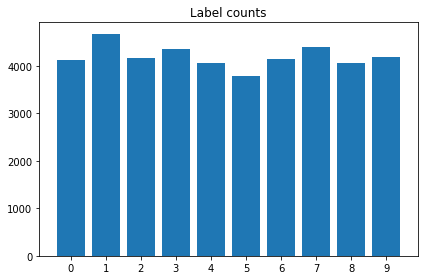

In [5]:
import numpy as np
import matplotlib.pyplot as plt

labels, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(6, 4))
plt.title('Label counts')
plt.bar(labels, counts)
plt.xticks(labels, labels)
plt.tight_layout()
plt.show()

### Train AutoKeras model

For MNIST handwritten numbers, a CNN model can generally perform very well, no need to do image augmentation. Training with a GTX 1660 Ti card.

In [6]:
import autokeras as ak
import tensorflow as tf

input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ConvBlock()(output_node)
output_node = ak.SpatialReduction()(output_node)
output_node = ak.ClassificationHead()(output_node)

clf = ak.AutoModel(
    inputs=input_node, outputs=output_node,
    max_trials=100, overwrite=True)

clf.fit(
    x_train, y_train, 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Trial 100 Complete [00h 17m 07s]
val_loss: 0.02712019719183445

Best val_loss So Far: 0.02712019719183445
Total elapsed time: 23h 51m 37s
INFO:tensorflow:Oracle triggered exit


Epoch 1/30
1313/1313 [==============================] - 31s 23ms/step - loss: 0.6606 - accuracy: 0.7830: 26s - los - ETA: 24s - loss: 1. - ETA: 2 - ETA: 20s - loss: 1.1763 - accurac - ETA: 19s - lo
Epoch 2/30
1313/1313 [==============================] - 29s 22ms/step - loss: 0.2118 - accuracy: 0.9347: 27s - loss: 0.2821 - accuracy: 0.918 - ETA: 27s - loss: 0.2831 - accuracy: 0.9 - ETA: 27s - loss: 0.2845 - accuracy: - ETA: 20s - loss: 0.2545 - accur - ETA: 19s - loss: 0.2551  - ETA: 18s - loss: 0.2555 - accuracy: 0.923 - ETA: 18s - loss: 0.2551 - accuracy: 0 - ETA: 17s - loss: 0.2528 -  - ETA: 13s - loss: 0.2434 - accuracy: 0.925 - ETA: 13s - loss: 0.2428 - accuracy: 0.92 - ETA:  - ETA: 11s - loss: 0.2337 - accuracy: 0 - ETA: 10s - loss: 0.23 - ETA: 9s - los - ETA: 4s - ETA: 0s - loss: 0.2125 - 
Epoch 3/30
1313/1313 [==============================] - 30s 23ms/step - loss: 0.1448 - accuracy: 0.9561: 28s - loss: 0.1625 - accur - - ETA: 24s - loss: 0.1693 - accuracy:   - - ETA: 2s - los -

Final training accuracy: 0.9944

In [7]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 28, 28)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 28, 28, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 28, 28, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 512)       74240     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 512)       0     

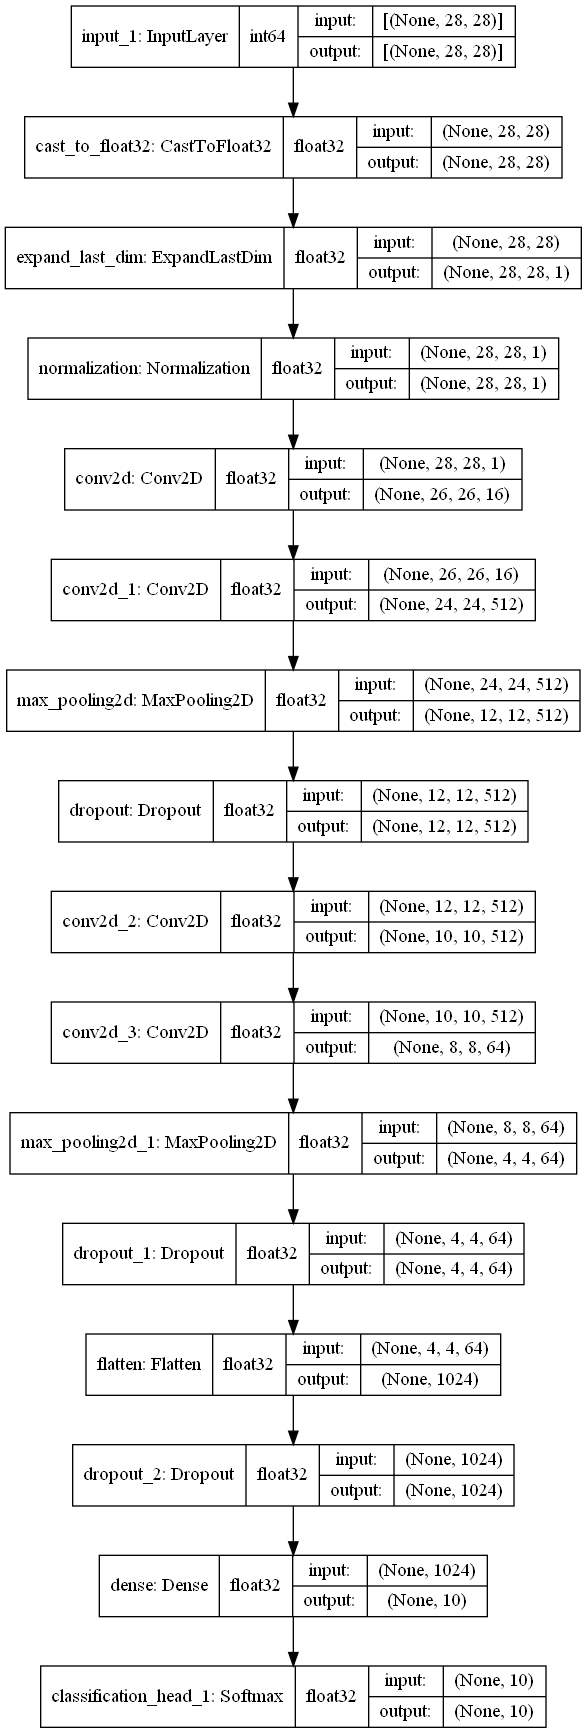

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names=True, show_shapes=True, show_dtype=True)

### Predict test labels

In [9]:
predicted = clf.predict(x_test).flatten().astype('uint8')

875/875 [==============================] - 4s 4ms/step


Inspect first 100 test numbers and their predicted labels:

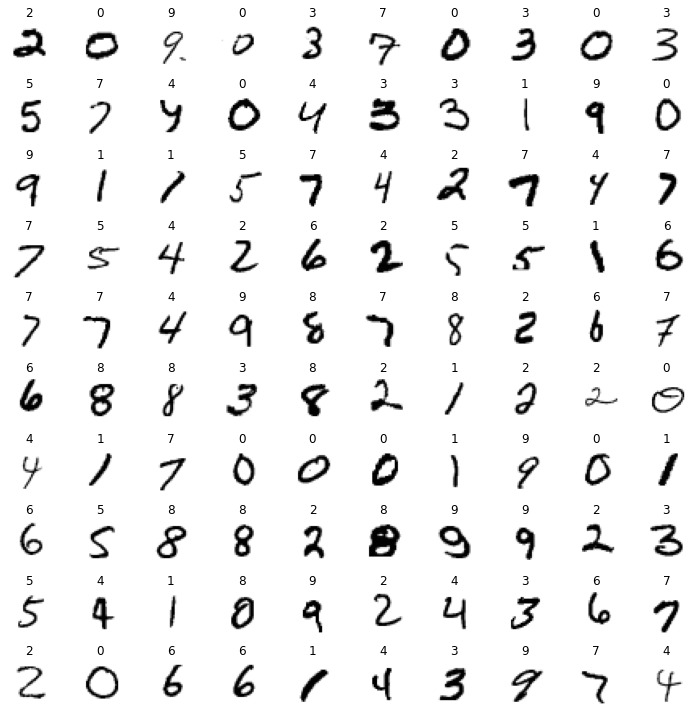

In [10]:
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.set_axis_off()
    plt.imshow(x_test[i], cmap='binary')
    ax.set_title(f'{predicted[i]}')
plt.tight_layout()
plt.show()

### Generate Kaggle submission

In [11]:
submission = pd.DataFrame({'ImageId': np.arange(x_test.shape[0])+1, 'Label': predicted})
submission.to_csv('./submission.csv', index=False)
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


* Kaggle score (accuracy): **0.99407**